### Running XY and Rydberg interaction

In [31]:
import matplotlib.pyplot as plt
from emu_mps import (
    MPS,
    MPSConfig, 
    MPSBackend,
    BitStrings,
    Fidelity,
    Occupation,
    StateResult
)

import pulser
from pulser.devices import MockDevice


import numpy as np
import torch

from math import pi
from pulser._hamiltonian_data import HamiltonianData

dtype = torch.complex128

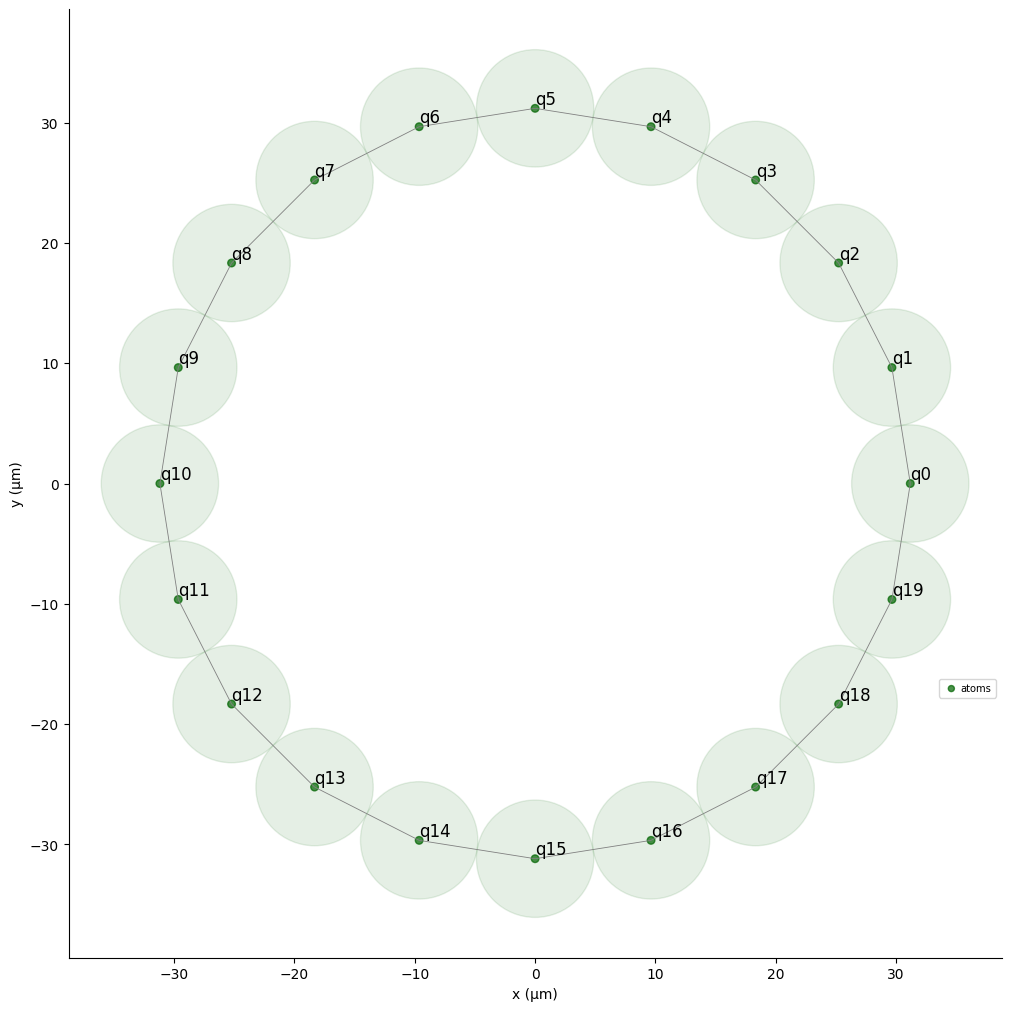

In [32]:
L = 20  # Number of atoms in the ring
Omega_max = 2 * np.pi
U = Omega_max 
# Define a ring of atoms distanced by a blockade radius distance:
R_interatomic = pulser.MockDevice.rydberg_blockade_radius(U)
coords = (
    R_interatomic
    / (2 * np.sin(np.pi / L))
    * np.array(
        [
            (np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L))
            for theta in range(L)
        ]
    )
)

# ring, periodic register
reg = pulser.Register.from_coordinates(coords, prefix="q")
# or try open boundaries
#reg = pulser.Register.rectangle(1,L,spacing=R_interatomic/1.2, prefix="q")

reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph=True)

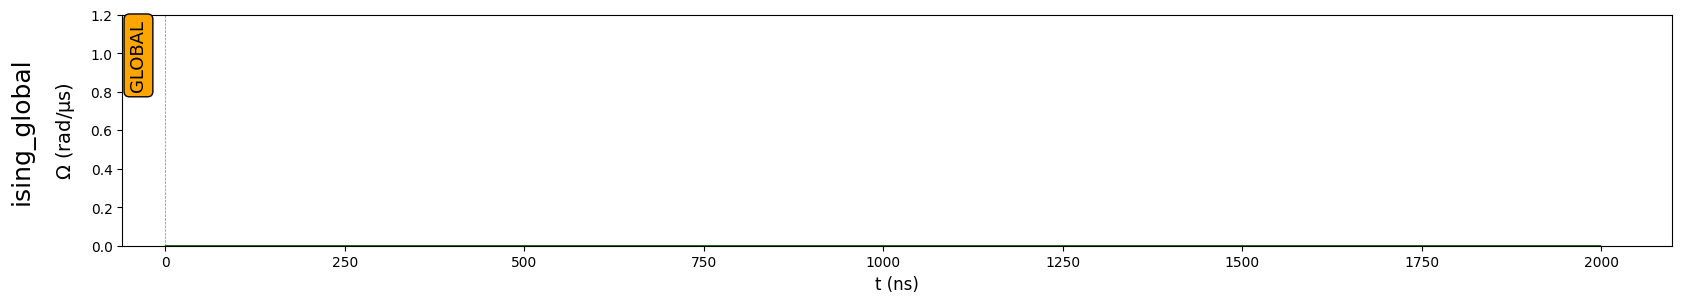

rydberg inter matr [[0.00000000e+00 6.28318516e+00 1.05749998e-01 1.05170493e-02
  2.23286473e-03 7.36655651e-04 3.28419280e-04 1.84030239e-04
  1.24433286e-04 9.91870466e-05 9.20819545e-05 9.91870466e-05
  1.24433286e-04 1.84030239e-04 3.28419280e-04 7.36655651e-04
  2.23286473e-03 1.05170493e-02 1.05749998e-01 6.28318516e+00]
 [6.28318516e+00 0.00000000e+00 6.28318516e+00 1.05749998e-01
  1.05170493e-02 2.23286473e-03 7.36655651e-04 3.28419280e-04
  1.84030239e-04 1.24433286e-04 9.91870466e-05 9.20819545e-05
  9.91870466e-05 1.24433286e-04 1.84030239e-04 3.28419280e-04
  7.36655651e-04 2.23286473e-03 1.05170493e-02 1.05749998e-01]
 [1.05749998e-01 6.28318516e+00 0.00000000e+00 6.28318516e+00
  1.05749998e-01 1.05170493e-02 2.23286473e-03 7.36655651e-04
  3.28419280e-04 1.84030239e-04 1.24433286e-04 9.91870466e-05
  9.20819545e-05 9.91870466e-05 1.24433286e-04 1.84030239e-04
  3.28419280e-04 7.36655651e-04 2.23286473e-03 1.05170493e-02]
 [1.05170493e-02 1.05749998e-01 6.28318516e+00 0

In [33]:
cons_amplitud = pulser.Pulse.ConstantAmplitude(
    0.0, pulser.waveforms.RampWaveform(2000, 0.0, 0.0), 0.0
)
seq = pulser.Sequence(reg, MockDevice)
seq.declare_channel("ising_global", "rydberg_global")
seq.add(cons_amplitud, "ising_global")
seq.draw()
rydberg_ham_data = HamiltonianData.from_sequence(seq)

interaction_matrix_rydberg = rydberg_ham_data._interaction_matrix
print("rydberg inter matr",interaction_matrix_rydberg)


### sequence with xy model that uses the previous register in order to get the interaction xy matrix
const_pulse = pulser.Pulse.ConstantAmplitude(
    0.0, pulser.waveforms.RampWaveform(200, 0.0, pi), 0.0
)
seq_xy = pulser.Sequence(reg, MockDevice) # MockDevice has xy and ryderberg
seq_xy.declare_channel("mw_global", "mw_global")
seq_xy.add(const_pulse, "mw_global")

xy_ham_data = HamiltonianData.from_sequence(seq_xy)

interaction_matrix_xy = torch.tensor(xy_ham_data._interaction_matrix)
print("xy inter matr",interaction_matrix_xy)


In [34]:
#initial state |x11111...>
basis = ("g","r","x") 
nqubits = len(seq.register.qubit_ids)

init_state = {"x"+"r"*(nqubits-1):1.0} # |> in ground-rydberg basis

init_state_mps = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=init_state
)
init_state_mps.factors[0]

tensor([[[0.+0.j],
         [0.+0.j],
         [1.+0.j]]], device='cuda:0', dtype=torch.complex128)

In [35]:
dt = 10
eval_times = [1.0]
eval_times_list = [0.0,0.5,1.0]  # 100 time steps

In [36]:
sampling_times = 1000
bitstrings = BitStrings(evaluation_times=eval_times, num_shots=sampling_times)

In [37]:
nqubits = len(seq.register.qubit_ids)

state_for_test = {"x"+"r"*(nqubits-1): 1.0} # |10101010> in ground-rydberg basis

mps_for_test = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=state_for_test
)
fidelity_mps_pure = Fidelity(evaluation_times=eval_times_list, state=mps_for_test)
density = Occupation(
    evaluation_times=[x/seq.get_duration() for x in range(0, seq.get_duration(), dt)]
)
state = StateResult(evaluation_times=eval_times)

In [38]:
# lindbladians are using the leakage state |x> as |r1>.
# the basis will be |g>, |r>, |x>=|r1>
l1 = torch.zeros(3, 3, dtype=dtype)
l1[1, 2] = 1.0  # l1 = |r><x| = |r><r1| for xy model 
l2 = l1.mT  # l2 = |x><r|= |r1><r| for xy model
lindbladians = [l1, l2]

noise_model = pulser.NoiseModel(
    eff_noise_opers=lindbladians,
    eff_noise_rates=(0.00, 0.00),  # decay from |r> to |r1> and from |r1> to |r>
    with_leakage=True,  # the leakage will be the |r1> for the xy model (|r> is |0>, |r1> is |1>)
)

In [39]:
mpsconfig = MPSConfig(
    dt=dt,
    #precision=1.0e-9,
    observables=[
        bitstrings,
        fidelity_mps_pure,
        density,
        state
    ],
    interaction_matrix_xy= interaction_matrix_xy,
    log_level=10,
    initial_state= init_state_mps,
    noise_model=noise_model
)


emu-mps allows only {'occupation', 'energy_second_moment', 'energy', 'energy_variance', 'bitstrings', 'statistics', 'correlation_matrix'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'fidelity', 'state'} using `optimize_qubit_ordering = False` instead.


In [40]:
sim = MPSBackend(seq, config=mpsconfig)

# results = []
# nruns = 50
# for _ in range(nruns):
#     results.append(sim.run())

results = sim.run()

emu-mps allows only {'occupation', 'energy_second_moment', 'energy', 'energy_variance', 'bitstrings', 'statistics', 'correlation_matrix'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'fidelity', 'state'} using `optimize_qubit_ordering = False` instead.
mps backend interaction matrix xy  tensor([[0.0000, 3.9837, 0.5168, 0.1630, 0.0751, 0.0431, 0.0288, 0.0216, 0.0177,
         0.0158, 0.0153, 0.0158, 0.0177, 0.0216, 0.0288, 0.0431, 0.0751, 0.1630,
         0.5168, 3.9837],
        [3.9837, 0.0000, 3.9837, 0.5168, 0.1630, 0.0751, 0.0431, 0.0288, 0.0216,
         0.0177, 0.0158, 0.0153, 0.0158, 0.0177, 0.0216, 0.0288, 0.0431, 0.0751,
         0.1630, 0.5168],
        [0.5168, 3.9837, 0.0000, 3.9837, 0.5168, 0.1630, 0.0751, 0.0431, 0.0288,
         0.0216, 0.0177, 0.0158, 0.0153, 0.0158, 0.0177, 0.0216, 0.0288, 0.0431,
         0.0751, 0.1630],
        [0.1630, 0.5168, 3.9837, 0.0000, 3.9837, 0.5168, 0.1630, 0.0751, 0.0431,
         0.0288, 0.0216, 0.0177, 0.

In [41]:
#aggregated_results = pulser.backend.Results.aggregate(results)
#print(aggregated_results.get_result_times(density.tag))
#print(aggregated_results.get_result(bitstrings.tag, 1.0))

The most frequent bitstring is ['11111111110111111111'] which was sampled 180 times


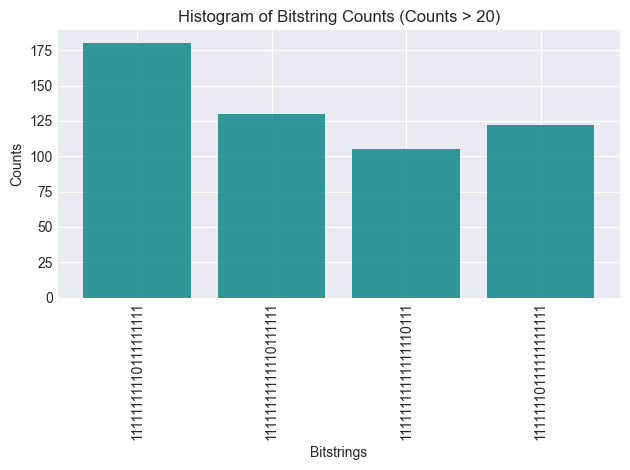

In [42]:
#aggregated_results.get_result_times(bitstrings.tag)
#bitstrings_final = aggregated_results.get_result(bitstrings.tag, 1.0)
results.get_result_times(bitstrings)
bitstrings_final = results.get_result(bitstrings,1.0)
max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print(
    "The most frequent bitstring is {} which was sampled {} times".format(
        max_string, max_val
    )
)

filtered_counts = [count for count in bitstrings_final.values() if count > 100]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 100
]
x_labels = range(len(filtered_bitstrings))
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

In [43]:
#aggregated_results.get_result_tags()

In [44]:
#fidelity_pure = aggregated_results.get_result(density.tag, 1.0)
fidelity_pure = results.get_result(fidelity_mps_pure,1.0)

print(
    "The probability of the system being in the sate |111111> is equal to {} ".format(
        fidelity_pure,
    )
)

for t in eval_times_list:
    print(results.get_result(fidelity_mps_pure, t))

The probability of the system being in the sate |111111> is equal to 0.015582771093291743 
tensor(1., dtype=torch.float64)
tensor(0.0142, dtype=torch.float64)
tensor(0.0156, dtype=torch.float64)


In [45]:
#magnetization_values = np.array(list(aggregated_results.occupation))
#magnetization_times = aggregated_results.get_result_times(density.tag) 
magnetization_values = np.array(list(results.occupation))
magnetization_times = results.get_result_times(density)

In [46]:
# rescaling the time
real_times = []
for time in magnetization_times:
    real_times.append(time * seq.get_duration())

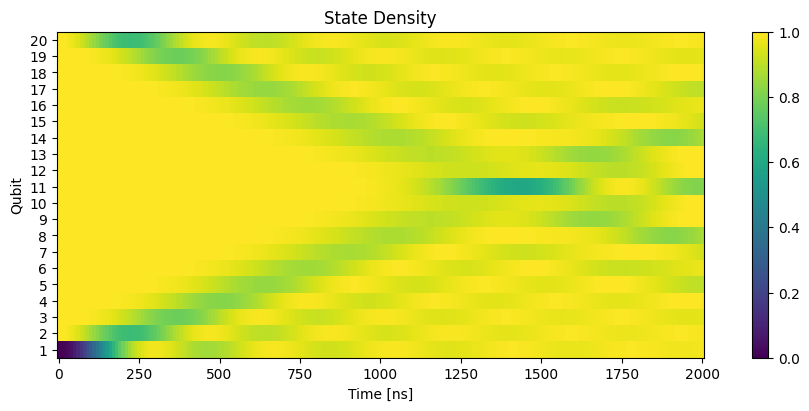

In [47]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

num_time_points, positions = magnetization_values.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = plt.pcolormesh(real_times, y, magnetization_values.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)

In [48]:
## cheking with pulser

### sequence with xy model that uses the previous register in order to get the interaction xy matrix
const_pulse = pulser.Pulse.ConstantAmplitude(
    0.0, pulser.waveforms.RampWaveform(2000, 0.0, pi), 0.0
)
seq_xy = pulser.Sequence(reg, MockDevice) # MockDevice has xy and ryderberg
seq_xy.declare_channel("mw_global", "mw_global")
seq_xy.add(const_pulse, "mw_global")

xy_ham_data = HamiltonianData.from_sequence(seq_xy)

In [64]:
#initial state |x11111...>
basis = ("0","1") 
nqubits = len(seq.register.qubit_ids)
mid_num_qubits = nqubits // 2
init_state = {"1"*(mid_num_qubits) +"0"+"1"*(nqubits - mid_num_qubits-1):1.0} # |> in ground-rydberg basis

init_state_mps_xy = MPS.from_state_amplitudes(
    eigenstates=basis, amplitudes=init_state
)
len(init_state_mps_xy.factors)
init_state_mps_xy.factors[11]


tensor([[[0.-0.j],
         [1.-0.j]]], device='cuda:0', dtype=torch.complex128)

In [65]:
mpsconfig_xy = MPSConfig(
    dt=dt,
    #precision=1.0e-9,
    observables=[
        bitstrings,
        #fidelity_mps_pure,
        density,
        state
    ],
    #interaction_matrix_xy= interaction_matrix_xy,
    log_level=10,
    initial_state= init_state_mps_xy,
    #noise_model=noise_model
)

emu-mps allows only {'occupation', 'energy_second_moment', 'energy', 'energy_variance', 'bitstrings', 'statistics', 'correlation_matrix'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'state'} using `optimize_qubit_ordering = False` instead.


In [66]:
sim = MPSBackend(seq_xy, config=mpsconfig_xy)

# results = []
# nruns = 50
# for _ in range(nruns):
#     results.append(sim.run())

results = sim.run()

emu-mps allows only {'occupation', 'energy_second_moment', 'energy', 'energy_variance', 'bitstrings', 'statistics', 'correlation_matrix'} observables with `optimize_qubit_ordering = True`. you provided unsupported {'state'} using `optimize_qubit_ordering = False` instead.
mps backend interaction matrix xy  tensor([], size=(0, 0), dtype=torch.complex128)
create impl interaction_matrix: tensor([], size=(0, 0), dtype=torch.complex128)
Will save simulation state to file "emu_mps_save_ab2970b4-f145-11f0-956b-0bebf727ee48.dat"
            every inf seconds.
To resume: `MPSBackend().resume("/home/mauro/Documents/pasqal/code/emulators/docs/emu_mps/notebooks/emu_mps_save_ab2970b4-f145-11f0-956b-0bebf727ee48.dat")`
init_hamiltonian interaction_matrix: tensor([], size=(0, 0), dtype=torch.complex128)
step = 1/200, χ = 2, |ψ| = 0.002 MB, RSS = 22.891 MB, Δt = 0.109 s
step = 2/200, χ = 2, |ψ| = 0.002 MB, RSS = 22.891 MB, Δt = 0.130 s
step = 3/200, χ = 2, |ψ| = 0.002 MB, RSS = 22.891 MB, Δt = 0.123 s

The most frequent bitstring is ['01111111111111111111'] which was sampled 173 times


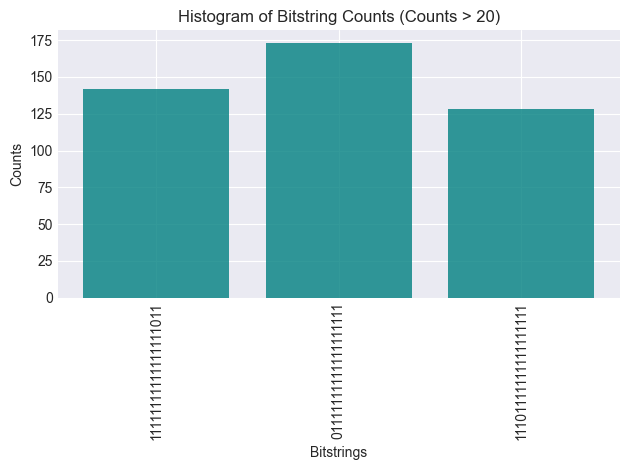

In [67]:
results.get_result_times(bitstrings)
bitstrings_final = results.get_result(bitstrings,1.0)
max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print(
    "The most frequent bitstring is {} which was sampled {} times".format(
        max_string, max_val
    )
)

filtered_counts = [count for count in bitstrings_final.values() if count > 100]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 100
]
x_labels = range(len(filtered_bitstrings))
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

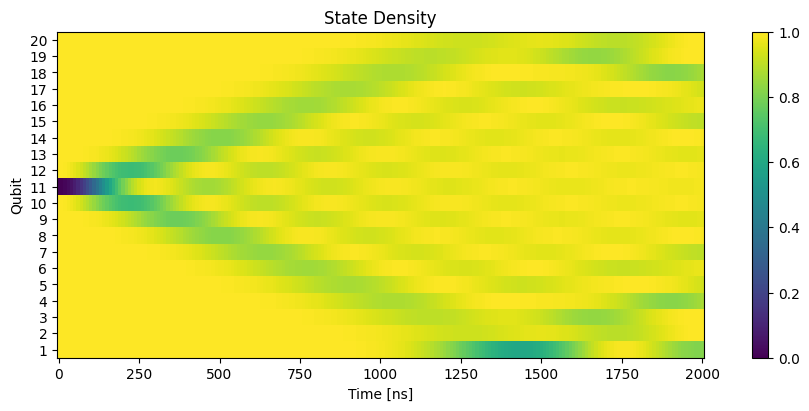

In [68]:
magnetization_values = np.array(list(results.occupation))
magnetization_times = results.get_result_times(density)
# rescaling the time
real_times = []
for time in magnetization_times:
    real_times.append(time * seq.get_duration())
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

num_time_points, positions = magnetization_values.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = plt.pcolormesh(real_times, y, magnetization_values.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)